### Critical windows with the causal RF: Analysis Phase 2 ("simple, more realistic")
- The objective of this analysis phase it to perform tests which incorporate correlation between exposure over time. The causal RF may have greater difficulty recovering the effect of correlated exposures.  
- All models use a random draw of 5000 exposure profiles from the cohort's actual exposure profiles, with an outcome based on actual birth weight mean and df. One exposure is confounding the critical exposure(s).   

**Model 2.A:** a critical exposure  
- 3 exposures: 1 critical, 1 not critical, 1 confounder on critical exposure  

**Model 2.B:** a naive critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

**Model 2.C:** a time-varying critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

**Model 2.D:** a concentrated critical exposure  
- 6 exposures: 1 critical, 4 not critical, 1 confounder on critical exposure  
- the exposure effect is concentrated (e.g., in week 3); i.e., the full effect of CW in model 1.C is concentrated in a single exposure  

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from econml.dml import CausalForestDML

In [61]:
np.random.seed(1004) # use throughout

Cohort information
Get the mean and SD for ozone exposure and birth weight.

In [62]:
births = pd.read_csv("data/birth_clean_wide_deidentified.csv")

o3_mean = births['max_o3_01'].mean()
o3_sd = births['max_o3_01'].std()

bw_mean = births["birthweightgrams"].mean()
bw_sd = births["birthweightgrams"].std()


#### Model 1.A
3 exposures: 1 critical, 1 not critical, 1 confounder on critical exposure  

##### "Data"
A few conventions: `T` is treatments, `W` is confounders (aka controls), and `X` is features (includes confounders and covariates, but not treatment). For all models in this project, `X = W`, as there are no covariates, only confounders.

In [63]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 3 # one critical, two not
n_W = 1 # one confounder

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_sample = births.sample(n = 5000)

o3_sd = T_sample['max_o3_01'].std()

T_1 = T_sample['max_o3_01'] / o3_sd
T_2 = T_sample['max_o3_02'] / o3_sd
T_3 = T_sample['max_o3_03'] / o3_sd

Look at correlation

In [64]:
T_vars = np.vstack((T_1, T_2, T_3))#, T_4, T_5))
correlation_matrix_np = np.corrcoef(T_vars)
print(correlation_matrix_np)

[[1.         0.86422598 0.83887585]
 [0.86422598 1.         0.86097746]
 [0.83887585 0.86097746 1.        ]]


Adjust the confounder so it is related to one treatment.

In [104]:
np.random.seed(1004)

## Confounder coefficient
b_W0T1 = 2.5
b_W0T2 = 2.5
b_W0T3 = 2.5
X = b_W0T1 * T_2 + b_W0T2 * T_2 + b_W0T3 * T_3 + np.random.normal(size=n_samples) - 40
# a 2.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

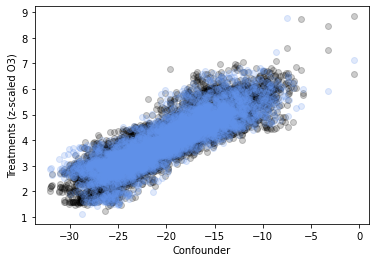

In [170]:
plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx
plt.plot(X, T_3, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx
plt.plot(X, T_2, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [106]:
## Coefficients
b_int = bw_mean + 600 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T1y = 0 # should have no effect
b_T2y = -70 # the critical exposure decreases bw by 70 g per one-sd increase
b_T3y = 0 # should have no effect
b_W0y = -35 # the confounder also decreases bw by 35 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_T3y * T_3 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3260.2554276717005
3232.7889730096877
536.5732455330558


160.5830359109379

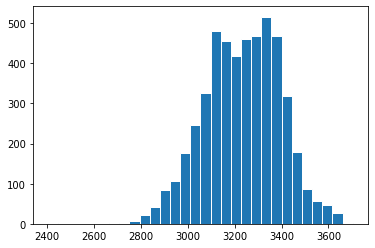

In [107]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
print(y.mean()) # this is about right
print(bw_sd)
y.std() # this is much too small ### will need to rectify this

Correlation between exposures, outcome

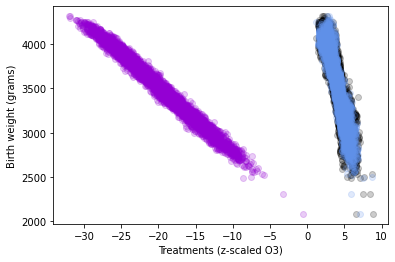

In [169]:
plt.plot(T_3, y, 'o', alpha = 0.2, color = "black") # noncritical tx in black
plt.plot(T_1, y, 'o', alpha = 0.2, color = "black") # noncritical tx in black
plt.plot(T_2, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in violet
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounders

In [119]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'critical_tx_2': T_2, 'noncritical_tx_3': T_3})
X = pd.DataFrame(X.to_numpy(), columns=['confounder'])
# y = pd.DataFrame({'birthweight': y})

##### Double ML
Before we go RF, just use `LinearDML`.

In [120]:
model_y = 'linear'
model_t = 'linear'

est = LinearDML(model_y=model_y, model_t=model_t,
                discrete_treatment=False) 

est.fit(y, T=T, W=X, X=X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/utilities.py:644: UserWarning: Not all column names are strings. Coercing to strings for now.
  warnings.warn("Not all column names are strings. Coercing to strings for now.", UserWarning)


In [121]:
est.marginal_ate_inference(T, X)
# note: if we drop the confounder from the model and this code here, the effect of T is inflated

Extract the marginal effects
- `marginal_ate` contains the mean point estimate for treatment effect  
- `marginal_ate_interval` contains the confidence intervals for the mean point estimate  
(This will be important as we scale up the number of treatments)  

In [123]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,-0.001731,0.004536,-0.007998
1,critical_tx_2,-69.993845,-69.982689,-70.005002
2,noncritical_tx_3,-0.002722,0.004561,-0.010006


Plot the marginal effects

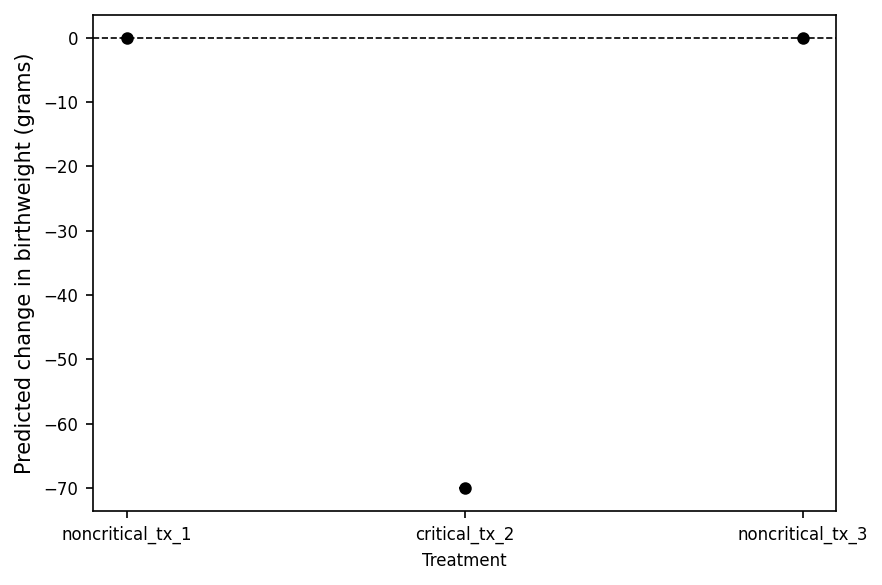

In [124]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.labels(res_df['treatment'])
# plt.savefig('raw_forest_plot.png')
plt.show()

##### Causal RF  
Now use the causal RF, same procedures as above.

In [125]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)
# note: it takes >100 times longer to run the causal RF over the linear model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/utilities.py:644: UserWarning: Not all column names are strings. Coercing to strings for now.
  warnings.warn("Not all column names are strings. Coercing to strings for now.", UserWarning)


Extract the marginal effects

In [ ]:
est.marginal_ate_inference(T, X)

In [126]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,-0.180183,1.591464,-1.951831
1,critical_tx_2,-70.018306,-65.650652,-74.385960
2,noncritical_tx_3,0.097320,2.480932,-2.286293


Plot the marginal effects

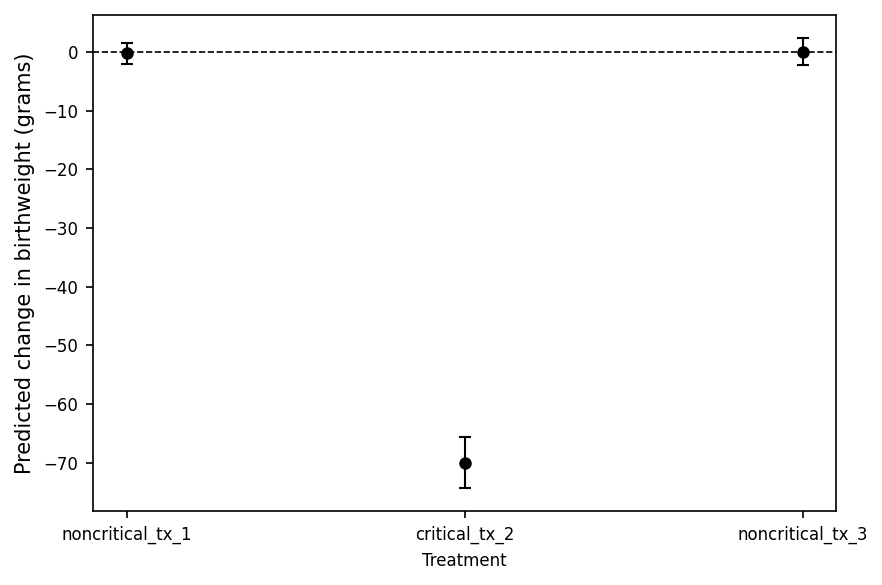

In [127]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

#### Model 1.B
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

##### "Data"

In [128]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 5 # one critical, one not
n_W = 1 # one confounder

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_sample = births.sample(n = 5000)

o3_sd = T_sample['max_o3_01'].std()

T_1 = T_sample['max_o3_01'] / o3_sd
T_2 = T_sample['max_o3_02'] / o3_sd
T_3 = T_sample['max_o3_03'] / o3_sd
T_4 = T_sample['max_o3_04'] / o3_sd
T_5 = T_sample['max_o3_05'] / o3_sd

Adjust the confounder so it is related to one treatment.

In [134]:
np.random.seed(1004)

## Confounder coefficient
# keeping equal for now
b_W0T1 = 0 # not critical, unconfounded
b_W0T2 = 2.5
b_W0T3 = 2.5
b_W0T4 = 2.5
b_W0T5 = 0 # not critical, unconfounded
X = b_W0T1 * T_1 + b_W0T2 * T_2 + b_W0T3 * T_3 + b_W0T4 * T_4 + b_W0T5 * T_5 + np.random.normal(size=n_samples) - 40
# a 2.5-unit increase in the confounder increases each exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

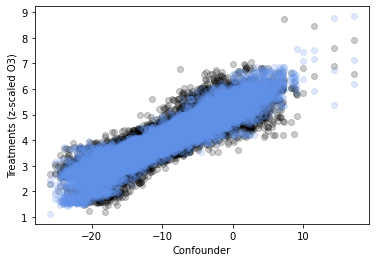

In [141]:
plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_5, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_2, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_3, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_4, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [144]:
## Coefficients
b_int = bw_mean + 500 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T2y = 0 # not critical, no effect
b_T2y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T3y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T4y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T5y = 0 # not critical, no effect
b_W0y = -35 # the confounder also decreases bw by 75 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_T3y * T_3 + b_T4y * T_4 + b_T5y * T_5 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3260.2554276717005
3275.0093262678606
536.5732455330558
443.0804080174326


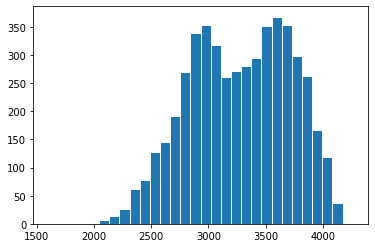

In [146]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
print(y.mean()) # this is about right
print(bw_sd)
print(y.std()) # only a bit too small

Correlation between exposures, confounder, outcome

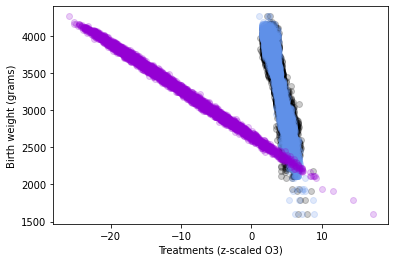

In [150]:
plt.plot(T_5, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_1, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_4, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_3, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_2, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in green
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounders, outcome

In [151]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'critical_tx_2': T_2,
                  'critical_tx_3': T_3, 'critical_tx_4': T_4,
                  'noncritical_tx_5': T_5})
X = pd.DataFrame(X, columns=['confounder'])

##### Causal RF

In [152]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)
# note: it takes >100 times longer to run the causal RF over the linear model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/utilities.py:644: UserWarning: Not all column names are strings. Coercing to strings for now.
  warnings.warn("Not all column names are strings. Coercing to strings for now.", UserWarning)


Extract the marginal effects

In [153]:
est.marginal_ate_inference(T, X)

In [154]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,0.058398,2.045758,-1.928963
1,critical_tx_2,-70.224486,-65.868035,-74.580938
2,critical_tx_3,-70.369056,-65.935969,-74.802144
3,critical_tx_4,-70.105977,-65.734196,-74.477758
4,noncritical_tx_5,0.103901,2.329152,-2.121351


Plot the marginal effects

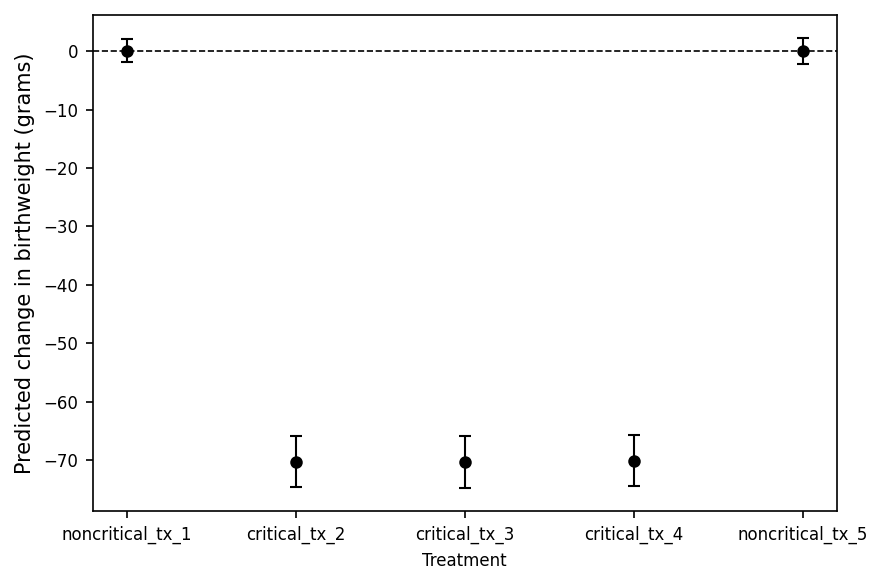

In [155]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

#### Model 1.C
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

##### "Data"

In [156]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 5 # one critical, one not
n_W = 1 # one confounder

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_sample = births.sample(n = 5000)

o3_sd = T_sample['max_o3_01'].std()

T_1 = T_sample['max_o3_01'] / o3_sd
T_2 = T_sample['max_o3_02'] / o3_sd
T_3 = T_sample['max_o3_03'] / o3_sd
T_4 = T_sample['max_o3_04'] / o3_sd
T_5 = T_sample['max_o3_05'] / o3_sd

Adjust the confounder so it is related to one treatment.

In [157]:
np.random.seed(1004)

## Confounder coefficient
# b_W0T1 = 2.5 # not critical
b_W0T2 = 2.5
b_W0T3 = 2.5
b_W0T4 = 2.5
# b_W0T5 = 2.5 # not critical
X = b_W0T1 * T_2 + b_W0T3 * T_3 + b_W0T4 * T_4 + np.random.normal(size=n_samples) - 40
# a 0.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

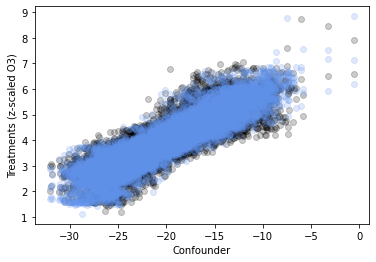

In [163]:
plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_5, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_2, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_3, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_4, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [159]:
## Coefficients
b_int = bw_mean + 400 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T2y = 0 # not critical, no effect
b_T2y = -60 # a one-sd increase in o3 decreases bw by 70 g
b_T3y = -90 # a one-sd increase in o3 decreases bw by 70 g
b_T4y = -60 # a one-sd increase in o3 decreases bw by 70 g
b_T5y = 0 # not critical, no effect
b_W0y = -35 # the confounder also decreases bw by 75 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_T3y * T_3 + b_T4y * T_4 + b_T5y * T_5 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3260.2554276717005
3523.4020973014094
536.5732455330558


362.8444775692011

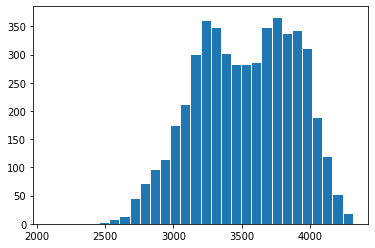

In [160]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
print(y.mean()) # this is about right
print(bw_sd)
y.std() # this is too small ### will need to rectify this

Correlation between exposures, outcome, confounder

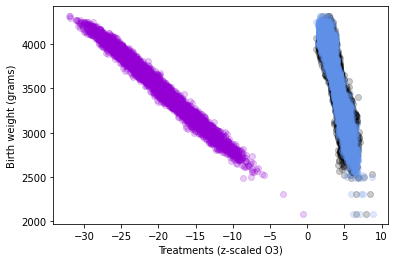

In [162]:
plt.plot(T_5, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_1, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_4, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_3, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_2, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in green
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounder, outcome

In [164]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'critical_tx_2': T_2,
                  'critical_tx_3': T_3, 'critical_tx_4': T_4,
                  'noncritical_tx_5': T_5})
X = pd.DataFrame(X, columns=['confounder'])

##### Causal RF

In [165]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/utilities.py:644: UserWarning: Not all column names are strings. Coercing to strings for now.
  warnings.warn("Not all column names are strings. Coercing to strings for now.", UserWarning)


Extract marginal effects

In [166]:
est.marginal_ate_inference(T, X)

In [167]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,-0.086230,2.445992,-2.618452
1,critical_tx_2,-59.611615,-56.551777,-62.671454
2,critical_tx_3,-89.300908,-84.635856,-93.965961
3,critical_tx_4,-59.692081,-55.247619,-64.136543
4,noncritical_tx_5,0.002385,2.760084,-2.755314


Plot the marginal effects

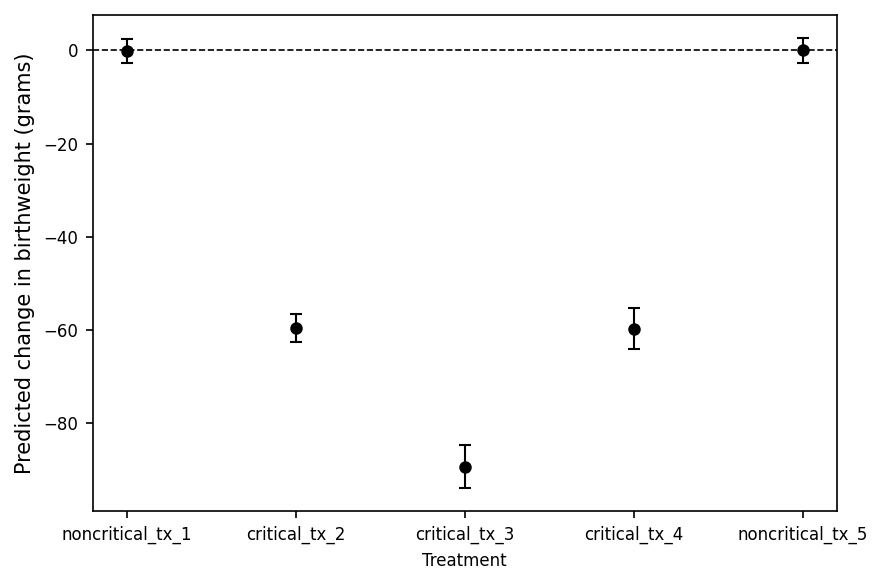

In [168]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()